# Lab Assignment Four: Evaluation and Multi-Layer Perceptron 

by Michael Han, Andrew Kozelsky, Ryan Cole, and Vince Miller

# Preparation

## Business Understanding
This data set consists of observations of astronomical objects made by the Sloan Digital Sky Survey (SDSS). The Sloan Digital Sky Survey is a multi-spectral imaging and spectroscopic redshift survey located at Apache Point Observatory in Sunspot, New Mexico. Objects are observed using a 2.5m telescope. Observations are divided into one of 3 classes: **Galaxy, Star,** or **Quasar** (denoted as QSO, which stands for quasi-stellar object). Quasars, contained in galactic nuclei, emit extremely large amounts of energy and are powered by supermassive black holes. 

We seek to develop a classifier that puts an astronomical object into one of these 3 categories based on the values of the observed attributes. As there are trillions of observable objects in our universe, classifying them manually (i.e. having an astronomer examine the data) may be completely unfeasable. An accurate classifier would allow new objects to be classified extremely quickly, thus allowing astronomers to rapidly build a database of newly observed objects in the sky, deepening our understanding of the observable universe. Of particular interest are the quasars and the black holes that they are associated with. Black holes are not yet fully understood, and so identifying and studying new quasars might be extremely useful in deepeing our understanding of them. The identification and classification of objects in this data set would help the SDSS construct a more detailed historical map of of the expansion of the universe after the Big Bang, as well as the growth of black holes over cosmic history.

## Attribute Definitions

The data set consists of 18 variables and 10,000 observations. The response variable, class, has three levels, as described above. 

The other **17** attributes are as follows: 
*****

- **Objid** (object identifier) identifies an object in the image catalog. Its a bit encoded integer of run, rerun, field, camcol, and object. Object simply identifies a specific object detected within a given image. It is not necessarily unique, and so we will drop it. 

- **SpecObjId** (object identifier) is a unique bit-encoded 64-bit ID used to identify optical spectroscopic objects. It is created using plate ID, MJD, and fiber ID. 

- **Right ascension (ra)** and **declination (dec)** are the celestial coordinates of the object being observed. Each point in the sky has unique celestial coordinates. 

- SDSS measures of the light of an observed object across the 5 bands of the 2.5m telescope. Each of these variables represents the response of one of those 5 bands:
    - **u: ultraviolet**
    - **g: green**
    - **r: red**
    - **i: near infared**
    - **z: infared**

- **field** contains the field number which is an image the telescope at SDDS takes

- **run** describes the specific scane of the image

- **camcol** is the scanline within a specific run

- **rerun** specifies how the image from which field was processed 

- **redshift**: As space itself is expanding, the wavelengths of light from objects far away from the earth will be lengthened, shifting it to the red side of the electromagnetic spectrum. 

- **MJD (Modified Julian Date)**: This indicates the date on which the observation was taken. 

- **plate (plate serial number)**: In the telescope, optical fibers are positioned at the locations of the images in the focal plane via holes drilled in a large, circular metal plate. These optical fibers relay information to a spectrograph, which analyzes the light from the image. Each plate has a unique serial number, which is recorded in the data set as plate number. 

- **fiberid (Fiber ID)** As stated above, the telescope uses optical fibers to direct light from an image to the spectrograph. Each object is assigned its own fiber ID. 


# Retained data
We read in the data and then convert it to a numpy matrix for use in classifiers. We drop the columns that have only one level and are thus useless in classification. We will also be dropping **specobjid, MJD, run, rerun, plate, camcol, and fiberid**, as these variables are related to the images captured and not the objects themselves.


The retained attributes are as follows: 
*****

- **Right ascension (ra)** and **declination (dec)** are the celestial coordinates of the object being observed. Each point in the sky has unique celestial coordinates. 

- SDSS measures of the light of an observed object across the 5 bands of the 2.5m telescope. Each of these variables represents the response of one of those 5 bands:
    - **u: ultraviolet**
    - **g: green**
    - **r: red**
    - **i: near infared**
    - **z: infared**

- **redshift**: As space itself is expanding, the wavelengths of light from objects far away from the earth will be lengthened, shifting it to the red side of the electromagnetic spectrum. 

- **class**: either Galaxy, Star, or Quasar (output variable)

- **class_code**: a numeric constructed field, with Galaxy = 0; QSO = 1, and Star = 2 (output variable code)


In [1]:
# use yaml to handle local differences
import yaml
my_settings = yaml.load(open('user.yaml', 'r'))
my_settings

{'data_path': 'C:\\Machine-Learning-Group\\Skyserver_SQL2_27_2018 6_51_39 PM.csv'}

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

%matplotlib inline

plt.style.use('ggplot')
# loading dataset into python
df = pd.read_csv(my_settings['data_path'])

# dropping unnecessary columns from dataset
df.drop(['objid','specobjid','mjd','run','camcol','field','rerun','fiberid','plate'],axis=1,inplace=True)

# assigning the target variable as category and one-hot encoding
df['class'] = df['class'].astype('category')
df['class_code'] = df['class'].cat.codes

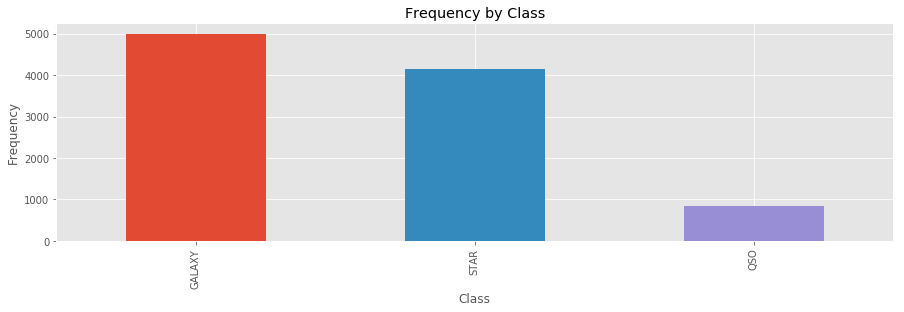

In [3]:
#Examine the distribution of classes in the training set
plt.figure(figsize=(15,4))
df['class'].value_counts().plot('bar')
plt.title('Frequency by Class')
plt.ylabel('Frequency')
plt.xlabel('Class')
plt.show()

X contains the light spectrum, the celestial coordinates indicated by the declination and right ascension, and the redshift and y is our target variable. The bar plot above shows a class imbalance. QSO or Quasars are under-represented in our dataset.

In [4]:
# separating target and data variables
y = np.asarray(df.class_code)
X = np.asarray(df.loc[:, (df.columns != 'class_code') & (df.columns != 'class')])

### Galaxy = 0; QSO = 1, Star = 2

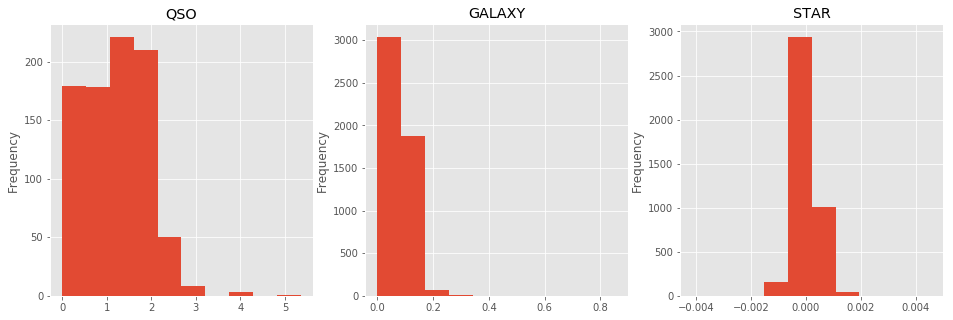

In [5]:
#Plot histograms of redshift by class
# Start by just plotting what we previously grouped!
plt.style.use('ggplot')

fig = plt.figure(figsize=(16,5))

ax1 = plt.subplot(1,3,1)
df[df['class']=='QSO'].redshift.plot.hist()
ax1.set_title('QSO')

ax2 = plt.subplot(1,3,2)
df[df['class']=='GALAXY'].redshift.plot.hist()
ax2.set_title('GALAXY')

ax3 = plt.subplot(1,3,3)
df[df['class']=='STAR'].redshift.plot.hist()
ax3.set_title('STAR')

plt.show()

The above is a plot of the **redshift** variable grouped by class. The distributions partially overlap, indicating that redshift alone is not sufficient to classify the records.

# Evaluation Metric 

Accuracy would be a poor measure of performance for this imbalanced dataset, since a high accuracy could be obtained by never predicting the under represented Quasar class.  Instead, we choose **F-score** as the best evaluation metric in this case. The F-score is defined as follows. 

$F-Score = \cfrac{2 * True Positives}{2 * True Positives + False Negatives + False Positives}$

The F-score ignores **True Negatives**, which is beneficial to our dataset because we are interested in a small under-represented group in our dataset. We know that the amount of True Negatives is going to be exceptionally high due to the class imbalance. 

For our business case, we are primarily interested in identifying existing quasars within this survey data that can then be individually studied.  Since this individual study is expensive, our goal is to identify likely candidates to maximize the likelihood that a location is a quasar.  We choose F score to balance the cost of individual study on an object that is not a quasar against the cost of failing properly classify an object that is a quasar.

## Method of training and testing sets

Because our class of interest is under represented, using k-fold cross validation could result in training the model without any of the interested class present in a particular fold.  To combat this issue, we use a **stratified 10-fold shuffle Split**.  This method is similiar to k-fold cross validation, but the data is randomly sampled by class to ensure that classes have the same representation in each fold as they do in the original data set. 

We will train on 60% of the model, use 20% for validation/hyper parameter tuning, and test on the remaining 20% of the original data.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import make_scorer, f1_score

# 60% for training data
X_train, X_test_tmp, y_train, y_test_tmp = train_test_split(scale(X), y, test_size=0.40, random_state=42, stratify = y, shuffle = True)

# splitting 'test' data into 20% validate/tuning and 20% test
X_test, X_val, y_test, y_val = train_test_split(X_test_tmp, y_test_tmp, test_size=0.50, random_state=42, stratify = y_test_tmp, shuffle = True)


# Modeling (45 points total)

### Custom Multi-Layer Perceptron
With selectable phi function for initial layers (including ReLU and SiLU), cost function, and number of hidden layers.

In [7]:
import numpy as np
from scipy.special import expit
import sys
import pandas as pd

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class LayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, num_layer = 1, which_phi = None, which_cost = None,
                 random_state=None, zero_grad=False, max_grad=False, norm_grad=False):    
        # if given seed use it, else allow randomness
        if random_state is not None:
            np.random.seed(random_state)
        self.n_hidden = n_hidden ## Number neurons
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.num_layer = num_layer ### number of layers
        self.which_phi = which_phi ### phi function
        self.cost_func = which_cost ### cost function
        self.zero_grad = zero_grad
        self.max_grad = max_grad
        self.norm_grad = norm_grad

        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    # using initialization method from Glorot and Bengio,  http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
    def _initialize_weights(self):
                
        """Initialize weights with small random numbers."""
        W = [0] * self.num_layer # saved as list of lists
        
        init_bound = np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        # Initial W1 matrix will have dim  n_hidden x n_features + 1
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-init_bound, init_bound, size=W1_num_elems)
        W[0] = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        # creating new layers with same dim: n_hidden x n_hidden+1
        for layer in range(1, self.num_layer-1):
            W_num_elems = (self.n_hidden + 1)*self.n_hidden
            W_tmp = np.random.uniform(-init_bound, init_bound, size = W_num_elems)
            W[layer] = W_tmp.reshape(self.n_hidden, self.n_hidden + 1)
        
        init_bound = np.sqrt(0.5 / (self.n_output_ + self.n_hidden + 1))
        # output layer that has dimensions of n_outputs x n_hidden+1
        Wout_num_elems = (self.n_hidden + 1)*self.n_output_
        Wout = np.random.uniform(-init_bound, init_bound, size=Wout_num_elems)
        W[-1] = Wout.reshape(self.n_output_, self.n_hidden + 1)
        
        # append last Weight matrix to W

        return W
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod ####### added linear activation function
    def _linear(z):
        return(z)
    
    @staticmethod ###### not yet implemented
    def _relu(z):
        return np.maximum(0,z.copy())
    
    @staticmethod ###### not yet implemented
    def _silu(z):
        return (z * expit(z))
        
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    
    #### Updated the following to include the new layers added 
    @staticmethod
    def _L2_reg(lambda_, W):
        """Compute L2-regularization cost"""
        W_mean = 0
        for layer in range(0, self.num_layer-1):
            W_mean += np.mean(W[layer][:,1:] ** 2)
        # only compute for non-bias terms                       
        return (lambda_/2.0) * np.sqrt(W_mean)
                                                                
    def _cost(self,A,Y_enc, W):
        if self.cost_func == "MSE":
            '''Get the objective function value'''
            cost = np.mean((Y_enc-A[-1])**2)
            L2_term = self._L2_reg(self.l2_C, W)
        elif self.cost_func == 'cross_ent':
            cost = -np.mean(np.nan_to_num((Y_enc*np.log(A[-1])+(1-Y_enc) * np.log(1-A[-1]))))
            L2_term = self._L2_ref(self.l2_C, W)
            
        return cost + L2_term
    

In [8]:
class LayerPerceptron(LayerPerceptronBase):
    def _feedforward(self, X, W):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        ### defines which phi activiation function to use 
        if self.which_phi == 'sigmoid':
            self._phi_func = self._sigmoid
        elif self.which_phi == 'linear':
            self._phi_func = self._linear
        elif self.which_phi == 'relu':
            self._phi_func = self._relu
        elif self.which_phi == 'silu':
            self._phi_func = self._silu
        else:
            print('no phi function inputted')
            
        # empty list to store results for A & Z
        A = [0] * (self.num_layer + 1) # plus b/c outer layer
        Z = [0] * self.num_layer
       
        # intial A and Z values
        A[0] = self._add_bias_unit(X.T, how='row')

        Z[0] = W[0] @ A[0]

        # iterate through layers to get A and Z's for each layer
        for layer in range(0, self.num_layer):
            A2 = self._phi_func(Z[layer])
            A2 = self._add_bias_unit(A2, how='row')
            
            # calculate the layers up until the final layer
            if layer < self.num_layer-1:
                Z2 = W[layer+1] @ A2
                A[layer+1] = A2
                Z[layer+1] = Z2

            elif layer == self.num_layer -1:
                # re-calculating the last layer
                
                ## sigmoid activation function applied to ReLu, Sigmoid, and SiLu. Linear remains
                if self._phi_func == 'linear':
                    A[-1] = self._linear(Z[layer])

                else:
                    A[-1] = self._sigmoid(Z[layer])

        return A, Z
    
    def _get_gradient(self, A, Z, Y_enc, W):
        """ Compute gradient step using backpropagation.
        """
        
        grad = [0] * len(W) ## empty list to store gradients    
        
        if self.cost_func == 'MSE': ## quadratic cost function
            V2 = -2*(Y_enc-A[-1])*A[-1]*(1-A[-1])
            
        elif self.cost_func == 'cross_ent': # cross entropy cost function
            V2 = A[-1] - Y_enc
        else:
            print('no cost function inputted: MSE or cross_ent')
            
        # first gradient calculation
        grad[-1] = V2 @ A[-2].T
        
        # vectorized backpropagation
        # iterate through number of layers to calculate sensitivity/gradient for each layer
        for layer in range(self.num_layer):
            
            if self.which_phi == 'sigmoid':
                V1 = (A[-(layer+2)]*(1-A[-(layer+2)]))*(W[-(layer+1)].T @ V2)
                if layer < self.num_layer - 1: # num_layer - 1 because how the gradient is iterated through for the next part
                    grad[-(layer+2)] = V1[1:,:] @ A[-(layer+3)].T
                    V2 = V1[1:,:]  # replace V2 with V1 without the bias term
                else:
                    pass # exiting loop after gradients have been calculated
                
            elif self.which_phi == 'linear':
                V1 = W[-(layer+1)].T @ V2 # derivative of linear function = 1
                if layer < self.num_layer - 1:
                    grad[-(layer+2)] = V1[1:,:] @ A[-(layer + 3)].T
                    V2 = V1[1:,:]
                else:
                    pass
                
            elif self.which_phi == 'relu':
                Z_with_bias = self._add_bias_unit(Z[layer], how = 'row')
                V1 = W[-(layer+1)].T @ V2
                if layer < self.num_layer - 1:
                    V1[Z_with_bias <= 0 ] = 0
                    grad[-(layer+2)] = V1[1:,:] @ A[-(layer + 3)].T
                    V2 = V1[1:,:]
                else:
                    pass
                        
            elif self.which_phi == 'silu':
                ## derivative of the silu f(x) + sigma(x)*f(1-x)
                V1 = (A[-(layer+2)] + self._sigmoid(A[-(layer+2)]) * (1- A[-(layer+2)])) * (W[-(layer+1)].T @ V2)
                if layer < self.num_layer - 1:
                    grad[-(layer+2)] = V1[1:,:] @ A[-(layer+3)].T
                    V2 = V1[1:,:]
                else:
                    pass
                
        for i in range(len(grad)): ## add weights to gradient
            grad[i][:,1:] += W[i][:, 1:] * self.l2_C
            # set to zero if small from below, not used here
            if self.zero_grad:
                grad[i][:,1:][np.abs(grad[i][:,1:]) < 1e-10] = 1e-10
            if self.norm_grad:
                tol = 5
                grad[i][np.abs(grad[i]) > tol] *= tol/np.linalg.norm(grad[i])
            # clip at maximum
            elif self.max_grad:
                # if except bias term, end up with very large bias terms
                grad[i][grad[i] > 5] = 5
                grad[i][grad[i] < -5] = -5            
        return grad
    
    def predict(self, X):
        """Predict class labels"""
        A, _ = self._feedforward(X, self.W) ## updated line to output 
        y_pred = np.argmax(A[-1], axis=0) # y_pred is the last matrix in A
        return y_pred
    

    def fit(self, X, y, print_progress=False, XY_test = None):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights() ### changed this with updated initialized weights

        self.score_= []
        self.val_score_ = []
        self.grad_w_ = np.full((self.epochs,self.num_layer),-1.0) #create full array to store avg layer weight by epoch
        
        for i in range(self.epochs):
            self.score_.append(f1_score(y_data,self.predict(X_data), average = 'micro'))
            
            if XY_test is not None:
                X_test = XY_test[0].copy()
                y_test = XY_test[1].copy()
                self.val_score_.append(f1_score(y_test,self.predict(X_test), average = 'micro'))
           
            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d--' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A, Z = self._feedforward(X_data,self.W) ## Adding the new W matrixes and new A1, Z
            #cost = self._cost(A3,Y_enc,self.W1,self.W2) ### this is just to graph - value of the MSE at the layer
            #self.cost_.append(cost)
      
            # compute gradient via backpropagation
            grad = self._get_gradient(A, Z, Y_enc, self.W)
            
            # save avg gradient for each layer
            for j in range(self.num_layer):
                self.grad_w_[i][j] = np.mean(grad[j])
    
            for layer in range(0, self.num_layer): # for loop that calculates new weight vector with gradient
                self.W[layer] -= self.eta * grad[layer]

        return self ## maintain convention with sckit-learn call .predict after .fit

### Hypertuning

In [9]:
# store results in dict using tuple as key
nns = {}

y_hats_train = {}
y_hats_validate = {}

f1s_train = {}
f1s_validate = {}

# use following syntax to save results.  Easier to iterate through multiple params this way
# nns[('linear','MSE',3)] = LayerPerceptron(**params)


In [10]:
%%time
params = dict(n_hidden=30, 
              C=0.1, # tradeoff L2 regularizer
              epochs=500, # iterations
              eta=0.0001,  # learning rate
              random_state=1 # set random seed
             )

phis = ['linear', 'sigmoid', 'relu', 'silu']
costs = ['MSE', 'cross_ent']
num_layers = [2, 3, 5, 7]


for this_phi in phis:
    for this_cost in costs:
        for this_num in num_layers:
            params['which_phi'] = this_phi
            params['which_cost'] = this_cost
            params['num_layer'] = this_num
             
            nns[(this_phi,this_cost,this_num)] = LayerPerceptron(**params)
            nns[(this_phi,this_cost,this_num)].fit(X_train, y_train, print_progress = 25, XY_test = (X_val, y_val))
            y_hats_train[(this_phi,this_cost,this_num)] = nns[(this_phi,this_cost,this_num)].predict(X_train)
            f1s_train[(this_phi,this_cost,this_num)] = f1_score(y_train,y_hats_train[(this_phi,this_cost,this_num)], average = 'micro')
            y_hats_validate[(this_phi,this_cost,this_num)] = nns[(this_phi,this_cost,this_num)].predict(X_val)
            f1s_validate[(this_phi,this_cost,this_num)] = f1_score(y_val,y_hats_validate[(this_phi,this_cost,this_num)], average = 'micro')


Epoch: 400/500--C:\Users\ryan.cole\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning:

invalid value encountered in maximum

C:\Users\ryan.cole\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning:

invalid value encountered in less_equal

Epoch: 50/500---C:\Users\ryan.cole\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning:

invalid value encountered in multiply

Epoch: 500/500--

Wall time: 12min 23s


Train - F1 Score for various combinations of activation, error, and number of layers


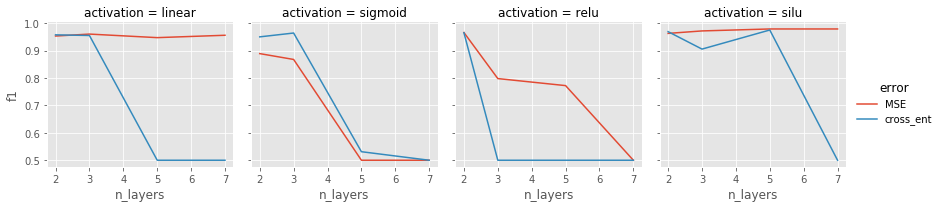

In [11]:
import itertools
# to dataframe
f1s_train_df = pd.DataFrame([[a, e, n, f1s_train[(a,e,n)]] for a,e,n in itertools.product(phis, costs, num_layers)], columns=['activation', 'error', 'n_layers', 'f1'])
f1s_validate_df = pd.DataFrame([[a, e, n, f1s_validate[(a,e,n)]] for a,e,n in itertools.product(phis, costs, num_layers)], columns=['activation', 'error', 'n_layers', 'f1'])

print('Train - F1 Score for various combinations of activation, error, and number of layers')
g = sns.FacetGrid(data=f1s_train_df, col='activation', hue='error')
g = (g.map(plt.plot, 'n_layers', 'f1')).add_legend()



Validate - F1 Score for various combinations of activation, error, and number of layers


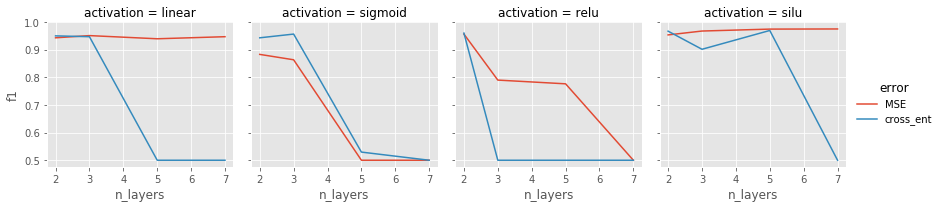

In [12]:
print('Validate - F1 Score for various combinations of activation, error, and number of layers')
g = sns.FacetGrid(data=f1s_validate_df, col='activation', hue='error')
g = (g.map(plt.plot, 'n_layers', 'f1')).add_legend()

The previous two groups of plots depict the F scores using various network depths for both training and validation data. The strong agreement between the training and validation data is discussed below.  It is notable that for all activation functions, when using cross entropy the F Score tends to decrease as the number of layers increases.  This behavior is also seen when using the MSE loss function paired with the sigmoid or ReLU activation functions.  Using MSE with the linear or SiLU activation functions does not strongly diminish the peformance of the nueral network, although large increases in performance are not seen.

Difference between Training and Validation F1-Scores


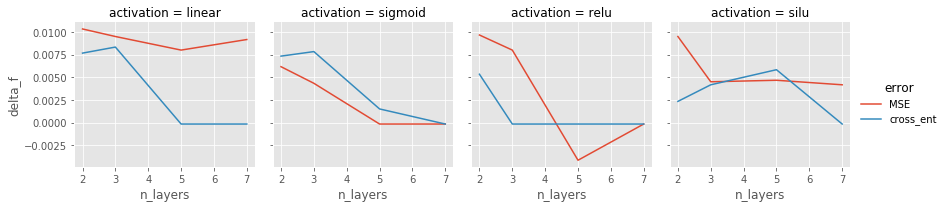

In [13]:
print('Difference between Training and Validation F1-Scores')
f1s_comb_df = pd.merge(f1s_train_df, f1s_validate_df, how='left', on=['activation', 'error', 'n_layers'], suffixes=['_trn', '_val'])
f1s_comb_df['delta_f'] = f1s_comb_df['f1_trn'] - f1s_comb_df['f1_val']
g = sns.FacetGrid(f1s_comb_df, col = 'activation', hue='error')
g = (g.map(plt.plot, 'n_layers', 'delta_f')).add_legend()


The plots above show the difference between the training and validation F scores at different n.  These differences small enough to be difficult to observe using the preceeding figures.  The largest difference observed is less than 5%.

In [14]:
def plot_f1_scores(nn, phis, costs, nums):
    plt.rcParams["figure.figsize"] = [15,12]
    colors = ['red', 'blue', 'black', 'orange']
    n_map = {2: (0,0),
               3: (0,1),
               5: (1,0),
               7: (1,1)}
    fig_num = 1
    for this_cost in costs:
        f, axes = plt.subplots(2,2, sharey=True, sharex=True)
        for a in f.axes:
            a.tick_params(
            which='both',       # both major and minor ticks are affected
            bottom=True,
            top=False,
            labelbottom=True,
            labelleft=True)
        f.set_label('x')
        for this_num in nums:
            ax_coords = n_map[this_num]
            colr = 0
            for this_phi in phis:
                this_nn = nns[(this_phi,this_cost,this_num)]
                axes[ax_coords[0], ax_coords[1]].plot(range(len(this_nn.score_)), this_nn.score_, label=this_phi, color=colors[colr])
                colr += 1
            axes[ax_coords[0], ax_coords[1]].set_xlabel('Epoch - N Layers = ' + str(this_num))
            axes[ax_coords[0], ax_coords[1]].set_ylabel('F Score')
            axes[ax_coords[0]][ax_coords[1]].legend(loc='lower right')
            plt.setp(axes[ax_coords[0]][ax_coords[1]].get_yticklabels(), visible=True)
            plt.suptitle('Validation Scores - Activation Function Comparison - ' + this_cost)
        plt.show()
        print('')



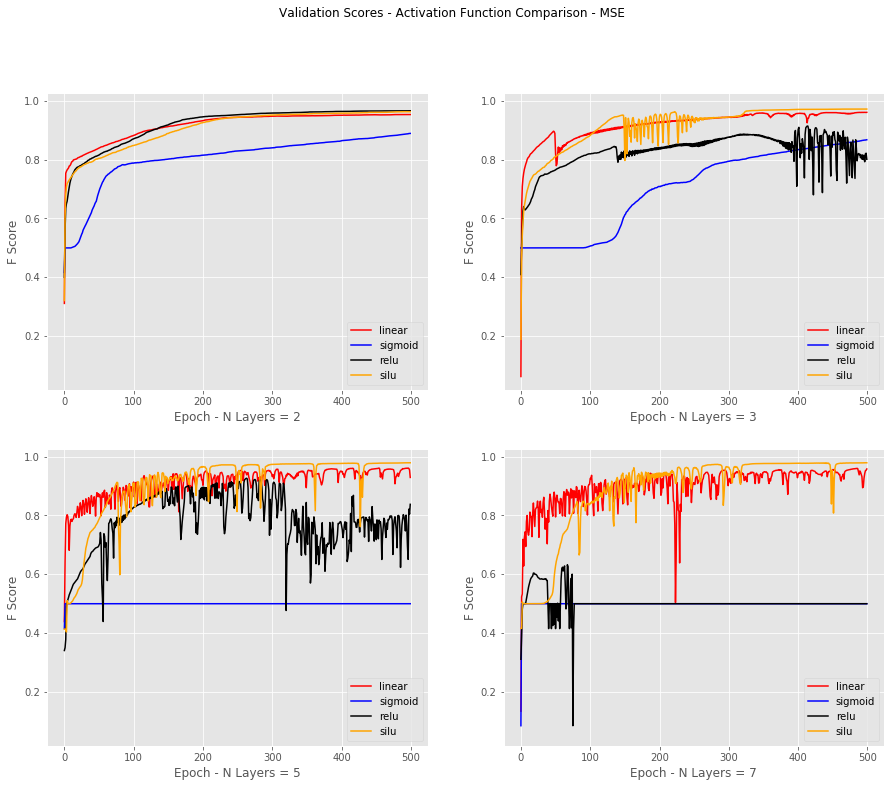

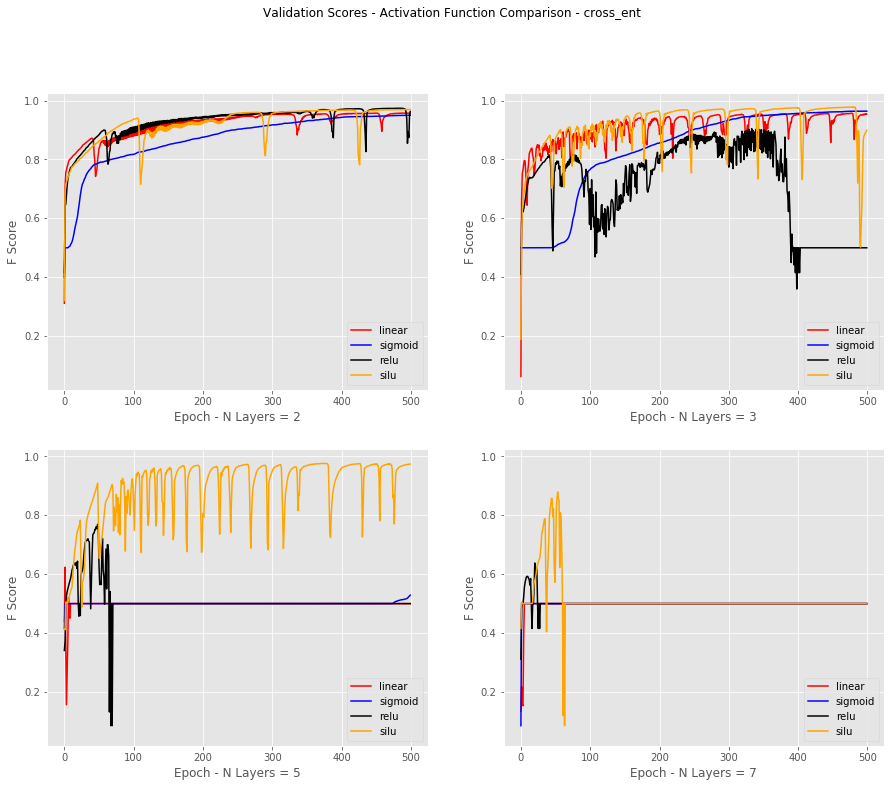

In [15]:
plot_f1_scores(nns, phis, costs, num_layers)

The plots above show the F Scores per epoch, and the deterioration of the classifier as the number of layers increase.  MSE appears to be more stable than Cross Entropy for small networks.  The instability appears to propagate through the network layers, as indicated by the increasing periodicity as the number of layers increases.

When performance is poor, the neural networks appear to deteriorate into random number generators, as an F-Score of 0.5 is equal to random classification.

Although the behavior is not shown here, we observed faster convergence using the initial weights proscribed by Glorot and Bengio than uniform [-1,1].

## Gradient Magnitudes

In [16]:
# plot gradients of each layer instead of averaging layers together
plt.rcParams["figure.figsize"] = [12,9]
def plot_layer_gradients(nns, nn_key, max_epoch=None):
    this_nn = nns[nn_key]
    n_layers = nn_key[2]
    if max_epoch == None:
        max_epoch == len(this_nn.grad_w_[:,0])
    colors = ['red', 'blue', 'black', 'orange', 'magenta', 'royalblue', 'crimson', 'grey']
    f, axes = plt.subplots(n_layers,1, sharey=False, sharex=True)
    for i in range(n_layers):
        axes[i].plot(range(len(this_nn.grad_w_[:max_epoch,i])), this_nn.grad_w_[:max_epoch,i], label='layer ' + str(i), color=colors[i])

    axes[-1].set_xlabel('Epoch')
    for i in range(n_layers):
        axes[i].set_ylabel('Layer ' + str(i+1))

    plt.suptitle('Average Gradients by Epoch\n' + str(nn_key))
    plt.show()

We are interested in the behavior of the gradients for each layer.  To avoid producing 32 plots (for each tuning configuration) we will examine the behavior of ReLU.

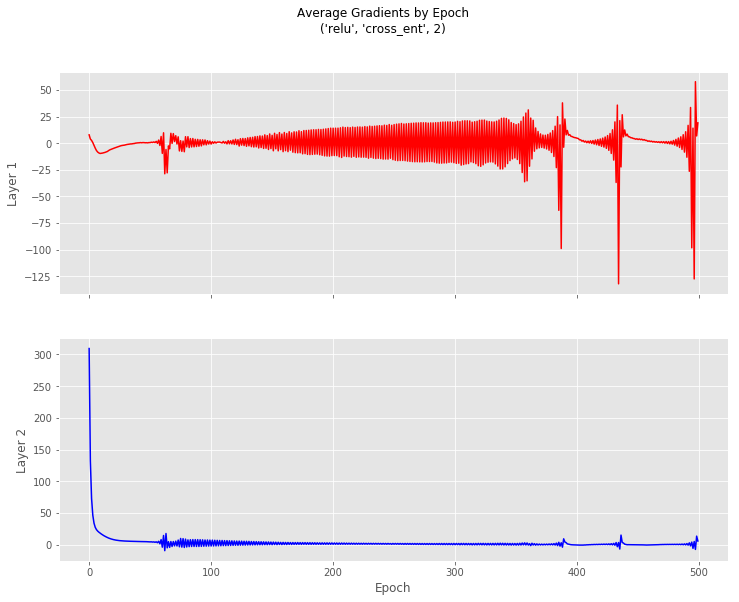

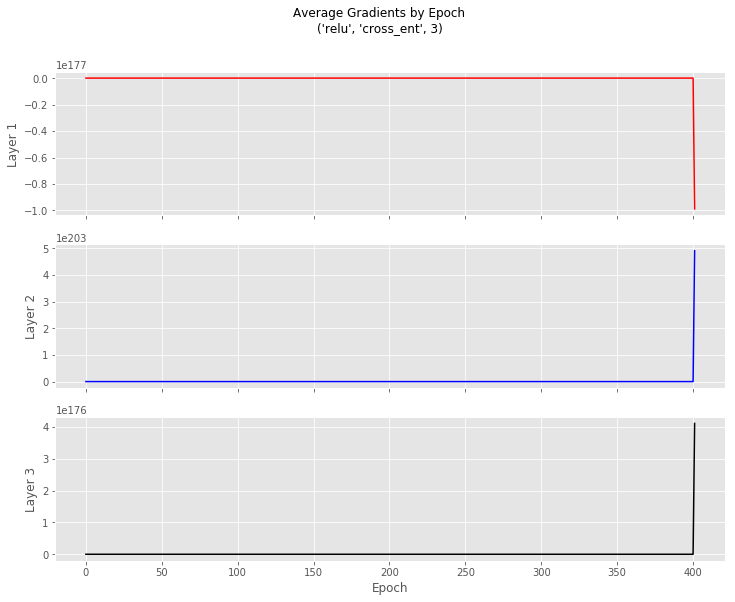

In [17]:
plot_layer_gradients(nns,('relu', 'cross_ent', 2))
plot_layer_gradients(nns,('relu', 'cross_ent', 3))


Note that the gradients move quickly to and then fluctuates around 0 when using two layers, but explodes to positive infinity around epoch 400 when using 3 layers.

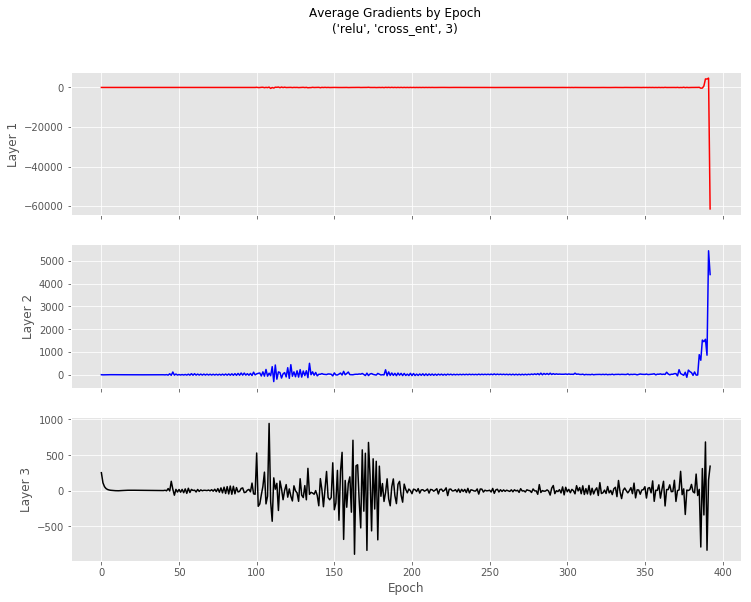

In [18]:
plot_layer_gradients(nns,('relu', 'cross_ent', 3), max_epoch=393)


The figure above shows the behavior of the average gradient by layer before the gradient explosion at epoch 395.  The explosion appears to begin in the first layer, with the other layers following quickly.  As the weights become extremely large and negative in layer 1, the weights in layer 2 become very large and positive while attempting to balance the regression equations.

With larger networks this explosion occurs more quickly.  Below, you can see the average weights (acrosss all layers) explode from $166$ to $-5 x 10^{153}$ between epochs 24 and 28 when using ReLU, 7 layers, and cross entropy.

In [19]:
j = 24
for i in np.mean(nns[('relu', 'cross_ent', 7)].grad_w_[24:30], axis=1):
    print('at epoch {0}, w = {1}'.format(j, i))
    j += 1

at epoch 24, w = 166.09358903686692
at epoch 25, w = -69.43452091553688
at epoch 26, w = -2609460.8431282896
at epoch 27, w = -2.0765994960944328e+27
at epoch 28, w = -5.227853839284735e+153
at epoch 29, w = nan


Below, we recreate and train the nueral networks, but enforce a strict limit that the gradient must be between -5 and 5.

In [20]:
%%time
params = dict(n_hidden=30, 
              C=0.1, # tradeoff L2 regularizer
              epochs=500, # iterations
              eta=0.0001,  # learning rate
              random_state=1, # set random seed
              max_grad=True # max gradient if very large
             )

nns_max_grad = {}
y_hats_train_max_grad = {}
y_hats_validate_max_grad = {}
f1s_train_max_grad = {}
f1s_validate_max_grad = {}

for this_phi in phis:
    for this_cost in costs:
        for this_num in num_layers:
            params['which_phi'] = this_phi
            params['which_cost'] = this_cost
            params['num_layer'] = this_num
             
            nns_max_grad[(this_phi,this_cost,this_num)] = LayerPerceptron(**params)
            nns_max_grad[(this_phi,this_cost,this_num)].fit(X_train, y_train, print_progress = 25, XY_test = (X_val, y_val))
            y_hats_train_max_grad[(this_phi,this_cost,this_num)] = nns_max_grad[(this_phi,this_cost,this_num)].predict(X_train)
            f1s_train_max_grad[(this_phi,this_cost,this_num)] = f1_score(y_train,y_hats_train_max_grad[(this_phi,this_cost,this_num)], average = 'micro')
            y_hats_validate_max_grad[(this_phi,this_cost,this_num)] = nns_max_grad[(this_phi,this_cost,this_num)].predict(X_val)
            f1s_validate_max_grad[(this_phi,this_cost,this_num)] = f1_score(y_val,y_hats_validate_max_grad[(this_phi,this_cost,this_num)], average = 'micro')

Epoch: 500/500--

Wall time: 14min 26s


{'n_hidden': 30, 'C': 0.1, 'epochs': 500, 'eta': 0.0001, 'random_state': 1, 'max_grad': True, 'which_phi': 'silu', 'which_cost': 'cross_ent', 'num_layer': 7}


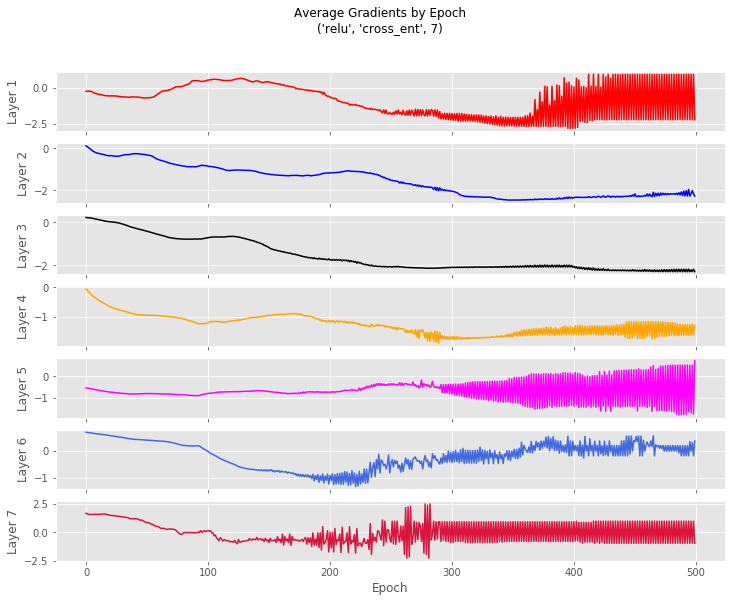

In [21]:
print(params)
plot_layer_gradients(nns_max_grad,('relu', 'cross_ent', 7))
# to dataframe
f1s_train_max_grad_df = pd.DataFrame([[a, e, n, f1s_train_max_grad[(a,e,n)]] for a,e,n in itertools.product(phis, costs, num_layers)], columns=['activation', 'error', 'n_layers', 'f1'])
f1s_validate_max_grad_df = pd.DataFrame([[a, e, n, f1s_validate_max_grad[(a,e,n)]] for a,e,n in itertools.product(phis, costs, num_layers)], columns=['activation', 'error', 'n_layers', 'f1'])


In these nueral networks we have clipped the gradient and forced it to be between -5 and 5, as shown in the previous plots.  These gradients are bounded but oscillate around a center value.  

Validate with Gradient clipped from above and below - F1 Score for various combinations of activation, error, and number of layers


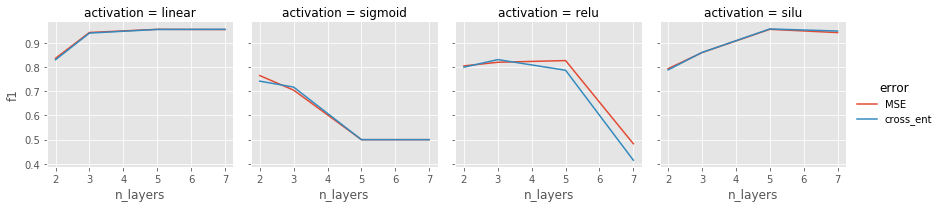

In [22]:
print('Validate with Gradient clipped from above and below - F1 Score for various combinations of activation, error, and number of layers')
g = sns.FacetGrid(data=f1s_validate_max_grad_df, col='activation', hue='error')
g = (g.map(plt.plot, 'n_layers', 'f1')).add_legend()

This has improved our accuracy for deeper networks using linear and SiLU activation functions, but has not improved performance using sigmoid or ReLU.

Below, if the gradient is > 5, we set it equal to $\cfrac{5 * grad}{||grad||_{L2}}$.

In [23]:
%%time
params = dict(n_hidden=30, 
              C=0.1, # tradeoff L2 regularizer
              epochs=500, # iterations
              eta=0.0001,  # learning rate
              random_state=1, # set random seed
              norm_grad=True # max gradient if very large
             )

nns_norm_grad = {}
y_hats_train_norm_grad = {}
y_hats_validate_norm_grad = {}
f1s_train_norm_grad = {}
f1s_validate_norm_grad = {}

for this_phi in phis:
    for this_cost in costs:
        for this_num in num_layers:
            params['which_phi'] = this_phi
            params['which_cost'] = this_cost
            params['num_layer'] = this_num
             
            nns_norm_grad[(this_phi,this_cost,this_num)] = LayerPerceptron(**params)
            nns_norm_grad[(this_phi,this_cost,this_num)].fit(X_train, y_train, print_progress = 25, XY_test = (X_val, y_val))
            y_hats_train_norm_grad[(this_phi,this_cost,this_num)] = nns_norm_grad[(this_phi,this_cost,this_num)].predict(X_train)
            f1s_train_norm_grad[(this_phi,this_cost,this_num)] = f1_score(y_train,y_hats_train_norm_grad[(this_phi,this_cost,this_num)], average = 'micro')
            y_hats_validate_norm_grad[(this_phi,this_cost,this_num)] = nns_norm_grad[(this_phi,this_cost,this_num)].predict(X_val)
            f1s_validate_norm_grad[(this_phi,this_cost,this_num)] = f1_score(y_val,y_hats_validate_norm_grad[(this_phi,this_cost,this_num)], average = 'micro')

Epoch: 500/500--

Wall time: 11min 40s


{'n_hidden': 30, 'C': 0.1, 'epochs': 500, 'eta': 0.0001, 'random_state': 1, 'norm_grad': True, 'which_phi': 'silu', 'which_cost': 'cross_ent', 'num_layer': 7}


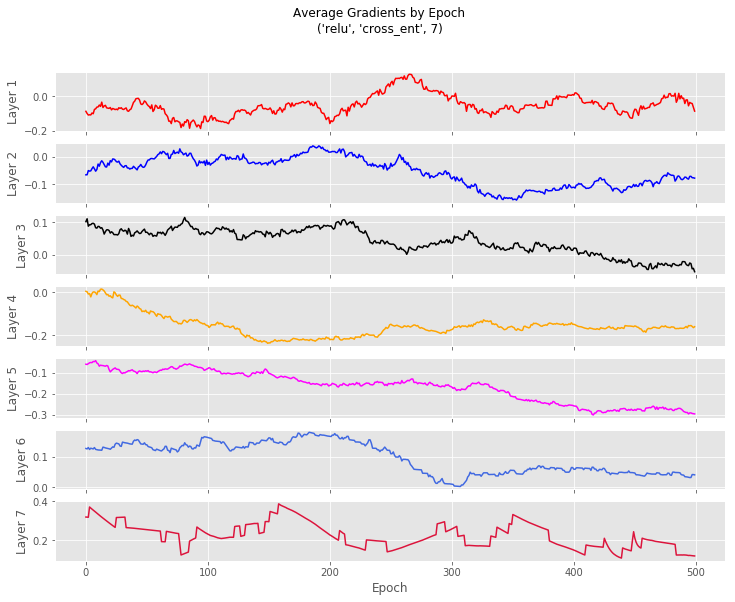

In [24]:
print(params)
plot_layer_gradients(nns_norm_grad,('relu', 'cross_ent', 7))
# to dataframe
f1s_train_norm_grad_df = pd.DataFrame([[a, e, n, f1s_train_norm_grad[(a,e,n)]] for a,e,n in itertools.product(phis, costs, num_layers)], columns=['activation', 'error', 'n_layers', 'f1'])
f1s_validate_norm_grad_df = pd.DataFrame([[a, e, n, f1s_validate_norm_grad[(a,e,n)]] for a,e,n in itertools.product(phis, costs, num_layers)], columns=['activation', 'error', 'n_layers', 'f1'])

In the plots above, we have divided the gradient by the L2 norm when it exceeds the threshold of 5.  This has the effect of bounding the gradients and they are no longer oscillating.  Instead the gradients are no longer smooth and appear disjoint, particularly for the 7th layer.


Validate with Gradient clipped from above and below - F1 Score for various combinations of activation, error, and number of layers


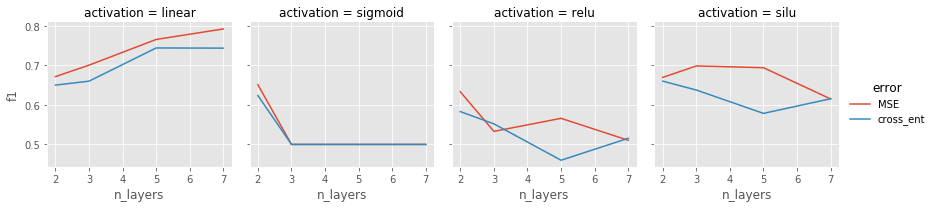

In [25]:
print('Validate with Gradient clipped from above and below - F1 Score for various combinations of activation, error, and number of layers')
g = sns.FacetGrid(data=f1s_validate_norm_grad_df, col='activation', hue='error')
g = (g.map(plt.plot, 'n_layers', 'f1')).add_legend()

Classification performance is worse across the board, so we will use the hard clipping of 5 instead of normed bound.

## Chosen Parameters

Below is a list of the best 5 performing tuning parameters from all combinations of activation function, loss function, and number of layers, for each of the 3 gradient options.

In [26]:
print('Using unbounded gradients\n', f1s_validate_df.sort_values('f1',ascending=False).head(5))
print('\nUsing hard clipping\n',f1s_validate_max_grad_df.sort_values('f1',ascending=False).head(5))
print('\nUsing normed clipping\n',f1s_validate_norm_grad_df.sort_values('f1',ascending=False).head(5))

Using unbounded gradients
    activation      error  n_layers      f1
27       silu        MSE         7  0.9750
26       silu        MSE         5  0.9745
30       silu  cross_ent         5  0.9695
25       silu        MSE         3  0.9675
28       silu  cross_ent         2  0.9670

Using hard clipping
    activation      error  n_layers      f1
30       silu  cross_ent         5  0.9570
2      linear        MSE         5  0.9555
7      linear  cross_ent         7  0.9555
26       silu        MSE         5  0.9555
6      linear  cross_ent         5  0.9550

Using normed clipping
   activation      error  n_layers      f1
3     linear        MSE         7  0.7920
2     linear        MSE         5  0.7655
6     linear  cross_ent         5  0.7440
7     linear  cross_ent         7  0.7435
1     linear        MSE         3  0.7005


We choose Silu with cross entropy and 5 layers as the best parameters to use, and obtain the following classification performance (F1 Score) on the test data.

In [28]:
y_hat_train = y_hats_train[('silu','cross_ent',5)]
y_hat_validate = y_hats_validate[('silu','cross_ent',5)]
y_hat_test = nns[('silu','cross_ent',5)].predict(X_test)

f1_test = f1_score(y_test,y_hat_test, average = 'micro')
print('F1 Score on test data using SiLU, cross entropy, and 5 layers:', f1_test)

F1 Score on test data using SiLU, cross entropy, and 5 layers: 0.974


# Exceptional Work (10 points total)
See Modeling section